In [191]:
import csv 
import pandas as pd
import numpy as np

dataframe = pd.read_csv('./Admission_Predict_Ver1.1_small_data_set_for_Linear_Regression.csv', na_values=['NA','?'])

In [192]:
import collections
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low

In [193]:
chance = dataframe['Chance of Admit ']

dataframe.drop('Chance of Admit ',1,inplace=True)

missing_median(dataframe, 'TOEFL Score')

encode_text_dummy(dataframe, 'University Rating')

x,y = to_xy(dataframe,"LOR ")

C:\Users\micke\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [194]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=40)

In [195]:
# Create linear regression object
model = linear_model.LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [196]:
pred = model.predict(x_test)
data = np.around(pred, 2)

In [197]:
for i in range(10):
    print("True chance of admit: ", chance[i], "Prediction: ", pred[i]) 

True chance of admit:  0.92 Prediction:  2.7135305
True chance of admit:  0.76 Prediction:  2.6513634
True chance of admit:  0.72 Prediction:  3.1635783
True chance of admit:  0.8 Prediction:  4.446154
True chance of admit:  0.65 Prediction:  2.9756176
True chance of admit:  0.9 Prediction:  2.5941403
True chance of admit:  0.75 Prediction:  4.058914
True chance of admit:  0.68 Prediction:  2.26238
True chance of admit:  0.5 Prediction:  2.8462274
True chance of admit:  0.45 Prediction:  2.4360383


In [198]:
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.6546403169631958


Root mean squared error = 0.6546
R-squared = 0.4027


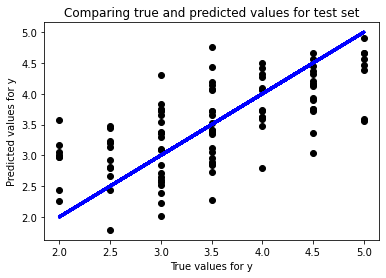

In [199]:
# Comparing true versus predicted values
plt.scatter(y_test, pred, color='black')
plt.plot(y_test, y_test, color='blue', linewidth=3)
plt.title('Comparing true and predicted values for test set')
plt.xlabel('True values for y')
plt.ylabel('Predicted values for y')

# Model evaluation
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y_test, pred)))
print('R-squared = %.4f' % r2_score(y_test, pred))

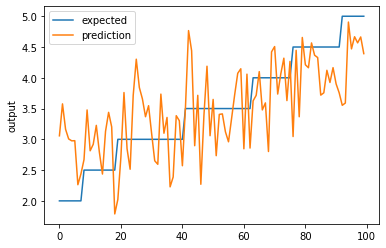

In [200]:
chart_regression(pred, y_test)

Text(0.5, 1.0, 'Correlation between X4 and X5 = -0.0975')

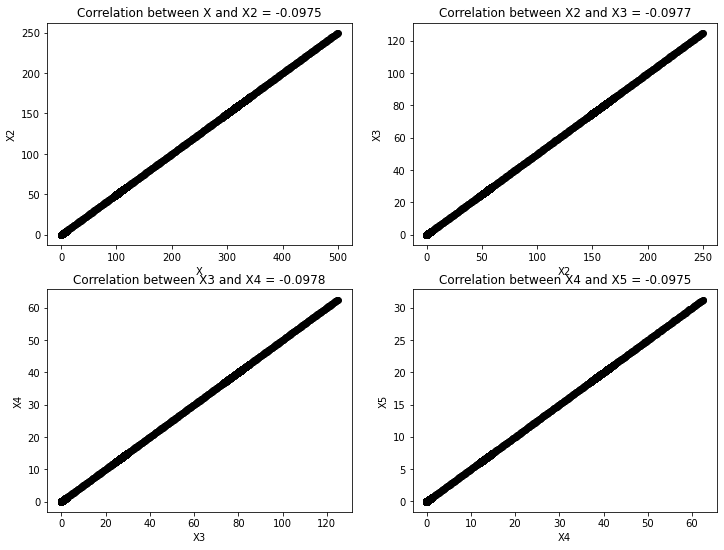

In [201]:
seed = 1
np.random.seed(seed)
x2 = 0.5*x + np.random.normal(0, 0.04, size=y.shape[0]).reshape(-1,1)
x3 = 0.5*x2 + np.random.normal(0, 0.01, size=y.shape[0]).reshape(-1,1)
x4 = 0.5*x3 + np.random.normal(0, 0.01, size=y.shape[0]).reshape(-1,1)
x5 = 0.5*x4 + np.random.normal(0, 0.01, size=y.shape[0]).reshape(-1,1)

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,9))
ax1.scatter(x, x2, color='black')
ax1.set_xlabel('X')
ax1.set_ylabel('X2')
c = np.corrcoef(np.column_stack((x[:-y_test.shape[0]],x2[:-y_test.shape[0]])).T)
titlestr = 'Correlation between X and X2 = %.4f' % (c[0,1])
ax1.set_title(titlestr)

ax2.scatter(x2, x3, color='black')
ax2.set_xlabel('X2')
ax2.set_ylabel('X3')
c = np.corrcoef(np.column_stack((x2[:-y_test.shape[0]],x3[:-y_test.shape[0]])).T)
titlestr = 'Correlation between X2 and X3 = %.4f' % (c[0,1])
ax2.set_title(titlestr)

ax3.scatter(x3, x4, color='black')
ax3.set_xlabel('X3')
ax3.set_ylabel('X4')
c = np.corrcoef(np.column_stack((x3[:-y_test.shape[0]],x4[:-y_test.shape[0]])).T)
titlestr = 'Correlation between X3 and X4 = %.4f' % (c[0,1])
ax3.set_title(titlestr)

ax4.scatter(x4, x5, color='black')
ax4.set_xlabel('X4')
ax4.set_ylabel('X5')
c = np.corrcoef(np.column_stack((x4[:-y_test.shape[0]],x5[:-y_test.shape[0]])).T)
titlestr = 'Correlation between X4 and X5 = %.4f' % (c[0,1])
ax4.set_title(titlestr)

In [202]:
X_train2 = np.column_stack((x[:-y_test.shape[0]],x2[:-y_test.shape[0]]))
X_test2 = np.column_stack((x[-y_test.shape[0]:],x2[-y_test.shape[0]:]))
X_train3 = np.column_stack((x[:-y_test.shape[0]],x2[:-y_test.shape[0]],x3[:-y_test.shape[0]]))
X_test3 = np.column_stack((x[-y_test.shape[0]:],x2[-y_test.shape[0]:],x3[-y_test.shape[0]:]))
X_train4 = np.column_stack((x[:-y_test.shape[0]],x2[:-y_test.shape[0]],x3[:-y_test.shape[0]],x4[:-y_test.shape[0]]))
X_test4 = np.column_stack((x[-y_test.shape[0]:],x2[-y_test.shape[0]:],x3[-y_test.shape[0]:],x4[-y_test.shape[0]:]))
X_train5 = np.column_stack((x[:-y_test.shape[0]],x2[:-y_test.shape[0]],x3[:-y_test.shape[0]],x4[:-y_test.shape[0]],x5[:-y_test.shape[0]]))
X_test5 = np.column_stack((x[-y_test.shape[0]:],x2[-y_test.shape[0]:],x3[-y_test.shape[0]:],x4[-y_test.shape[0]:],x5[-y_test.shape[0]:]))

In [203]:
regr2 = linear_model.LinearRegression()
regr2.fit(X_train2, y_train)

regr3 = linear_model.LinearRegression()
regr3.fit(X_train3, y_train)

regr4 = linear_model.LinearRegression()
regr4.fit(X_train4, y_train)

regr5 = linear_model.LinearRegression()
regr5.fit(X_train5, y_train)

LinearRegression()

In [204]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
y_pred_train2 = regr2.predict(X_train2)
y_pred_test2 = regr2.predict(X_test2)
y_pred_train3 = regr3.predict(X_train3)
y_pred_test3 = regr3.predict(X_test3)
y_pred_train4 = regr4.predict(X_train4)
y_pred_test4 = regr4.predict(X_test4)
y_pred_train5 = regr5.predict(X_train5)
y_pred_test5 = regr5.predict(X_test5)

In [205]:
columns = ['Model', 'Train error', 'Test error', 'Sum of Absolute Weights']
model1 = "%.2f X + %.2f" % (model.coef_[0][0], model.intercept_[0])
values1 = [ model1, np.sqrt(mean_squared_error(y_train, y_pred_train)), 
           np.sqrt(mean_squared_error(y_test, y_pred_test)),
           np.absolute(model.coef_[0]).sum() + np.absolute(model.intercept_)]

model2 = "%.2f X + %.2f X2 + %.2f" % (regr2.coef_[0][0], regr2.coef_[0][1], regr2.intercept_[0])
values2 = [ model2, np.sqrt(mean_squared_error(y_train, y_pred_train2)), 
           np.sqrt(mean_squared_error(y_test, y_pred_test2)),
           np.absolute(regr2.coef_[0]).sum() + np.absolute(regr2.intercept_[0])]

model3 = "%.2f X + %.2f X2 + %.2f X3 + %.2f" % (regr3.coef_[0][0], regr3.coef_[0][1], 
                                                regr3.coef_[0][2], regr3.intercept_[0])
values3 = [ model3, np.sqrt(mean_squared_error(y_train, y_pred_train3)), 
           np.sqrt(mean_squared_error(y_test, y_pred_test3)),
           np.absolute(regr3.coef_[0]).sum() + np.absolute(regr3.intercept_[0])]

model4 = "%.2f X + %.2f X2 + %.2f X3 + %.2f X4 + %.2f" % (regr4.coef_[0][0], regr4.coef_[0][1], 
                                        regr4.coef_[0][2], regr4.coef_[0][3], regr4.intercept_[0])
values4 = [ model4, np.sqrt(mean_squared_error(y_train, y_pred_train4)), 
           np.sqrt(mean_squared_error(y_test, y_pred_test4)),
           np.absolute(regr4.coef_[0]).sum() + np.absolute(regr4.intercept_[0])]

model5 = "%.2f X + %.2f X2 + %.2f X3 + %.2f X4 + %.2f X5 + %.2f" % (regr5.coef_[0][0], 
                                        regr5.coef_[0][1], regr5.coef_[0][2], 
                                        regr5.coef_[0][3], regr5.coef_[0][4], regr5.intercept_[0])
values5 = [ model5, np.sqrt(mean_squared_error(y_train, y_pred_train5)), 
           np.sqrt(mean_squared_error(y_test, y_pred_test5)),
           np.absolute(regr5.coef_[0]).sum() + np.absolute(regr5.intercept_[0])]

results = pd.DataFrame([values1, values2, values3, values4, values5], columns=columns)

plt.plot(results['Sum of Absolute Weights'], results['Train error'], 'ro-')
plt.plot(results['Sum of Absolute Weights'], results['Test error'], 'k*--')
plt.legend(['Train error', 'Test error'])
plt.xlabel('Sum of Absolute Weights')
plt.ylabel('Error rate')

results

IndexError: invalid index to scalar variable.

Slope =  0.00045937835
Intercept =  0.2082305


Text(0, 0.5, 'y')

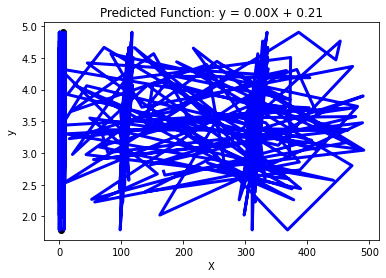

In [206]:
# Display model parameters
print('Slope = ', model.coef_[0])
print('Intercept = ', model.intercept_)### Step 4: Postprocessing

# Plot outputs
plt.scatter(y_test, pred,  color='black')
plt.plot(x_test, pred, color='blue', linewidth=3)
titlestr = 'Predicted Function: y = %.2fX + %.2f' % (model.coef_[0], model.intercept_)
plt.title(titlestr)
plt.xlabel('X')
plt.ylabel('y')

In [207]:
# Build network
model_relu = Sequential()
model_relu.add(Dense(60, input_dim=x_train.shape[1], activation='relu')) 
model_relu.add(Dense(30, activation='relu')) # Hidden 2
model_relu.add(Dense(1)) # Output
model_relu.compile(loss='mean_squared_error', optimizer='adam')
model_relu.fit(x_train,y_train,verbose=1,epochs=100) 

Epoch 1/100
13/13 [==============================] - 0s 2ms/step - loss: 83.6840
Epoch 2/100
13/13 [==============================] - 0s 2ms/step - loss: 12.0741
Epoch 3/100
13/13 [==============================] - 0s 2ms/step - loss: 5.0748
Epoch 4/100
13/13 [==============================] - 0s 2ms/step - loss: 1.8780
Epoch 5/100
13/13 [==============================] - 0s 2ms/step - loss: 1.5315
Epoch 6/100
13/13 [==============================] - 0s 2ms/step - loss: 1.1599
Epoch 7/100
13/13 [==============================] - 0s 2ms/step - loss: 1.0109
Epoch 8/100
13/13 [==============================] - 0s 2ms/step - loss: 0.9232
Epoch 9/100
13/13 [==============================] - 0s 2ms/step - loss: 0.9105
Epoch 10/100
13/13 [==============================] - 0s 2ms/step - loss: 0.8277
Epoch 11/100
13/13 [==============================] - 0s 2ms/step - loss: 0.7696
Epoch 12/100
13/13 [==============================] - 0s 1ms/step - loss: 0.7059
Epoch 13/100
13/13 [===============

In [208]:
# Predict MPG
pred_nn = model_relu.predict(x_test)
print("Shape: {}".format(pred_nn.shape))

Shape: (100, 1)


In [209]:
# Measure RMS error.  RMSE is common for regression.

score_nn = np.sqrt(mean_squared_error(y_test,pred_nn))
print("Final score (RMSE): {}".format(score_nn))
print('R2 score: %.2f' % r2_score(y_test, pred_nn))

Final score (RMSE): 0.7554833292961121
R2 score: 0.20


Text(0, 0.5, 'Predicted values for y')

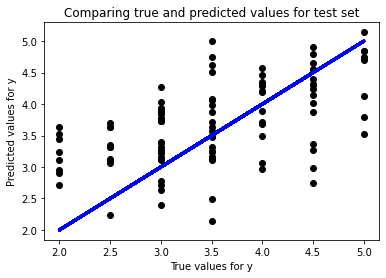

In [210]:
# Comparing true versus predicted values
plt.scatter(y_test, pred_nn, color='black')
plt.plot(y_test, y_test, color='blue', linewidth=3)
plt.title('Comparing true and predicted values for test set')
plt.xlabel('True values for y')
plt.ylabel('Predicted values for y')

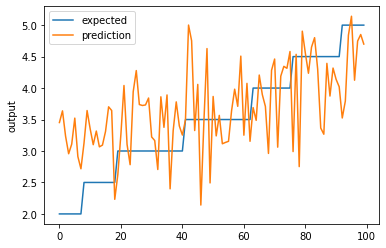

In [211]:
#Regression lift Chart
chart_regression(pred_nn.flatten(),y_test)